In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model

In [3]:
PATH = '/content/drive/MyDrive/input/sparta/'

enrolled = pd.read_csv(PATH + 'enrolleds_210729.csv')
pre = pd.read_csv(PATH + 'prequestions_210729.csv')
course = pd.read_csv(PATH + 'courses_210729.csv')

print(pre.shape)
print(enrolled.shape)
print(course.shape)

(48708, 6)
(67321, 7)
(50, 2)


In [4]:
pre.head(3)

,user_id,course_id,round_id,job,age,gender
0,2397731931fe978eb349,bdd218f17ec6313b96f3,655f288f4382b12fd3d9,직장인,30,남
1,5eb42ddf1cda5ff826f2,bdd218f17ec6313b96f3,655f288f4382b12fd3d9,창업/사업,34,남
2,012a9585146a4ddc9f29,bdd218f17ec6313b96f3,655f288f4382b12fd3d9,직장인,32,여


In [5]:
enrolled.head(3)

,enrolled_id,course_id,round_id,user_id,is_registered,start_date,end_date
0,29b2fc3febbed0d1bb56,bdd218f17ec6313b96f3,655f288f4382b12fd3d9,2151609483dab408339c,1,2020-08-03 00:00:00,2020-09-14 00:00:00
1,4baff9a5673307bba05e,bdd218f17ec6313b96f3,68fba9c86e209702cf6e,aaf0bbc09859eb9d2c51,0,2020-10-26 00:00:00,2020-12-07 00:00:00
2,993102db7757f4ddb425,bdd218f17ec6313b96f3,2143eff71c2f464d92ba,aaf0bbc09859eb9d2c51,0,2020-11-23 00:00:00,2020-12-28 00:00:00


In [6]:
course.head(3)

,course_id,title
0,bdd218f17ec6313b96f3,웹개발 종합반
1,cf06e86a19be34ec1e78,앱개발 종합반
2,8e02dc4b2b82e9a15e1e,파이썬 데이터분석 첫걸음


# 데이터 전처리

## User 데이터

In [7]:
user_data = pre[['user_id', 'job', 'age', 'gender']]
user_data['job'].unique()

array(['직장인', '창업/사업', '대학생', '무직/준비중', '기타', '학생', '2. 직장인', '4. 무직/준비중',
       '1. 학생', '5. 기타', '3. 창업/사업'], dtype=object)

In [9]:
user_data['job'] = user_data['job'].replace({'1. 학생': '학생',
                                             '2. 직장인': '직장인',
                                             '3. 창업/사업': '창업/사업',
                                             '4. 무직/준비중': '무직/준비중',
                                             '5. 기타': '기타'
                                             })
user_data['job'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array(['직장인', '창업/사업', '대학생', '무직/준비중', '기타', '학생'], dtype=object)

In [10]:
user_data.shape

(48708, 4)

In [11]:
user_data.head()

,user_id,job,age,gender
0,2397731931fe978eb349,직장인,30,남
1,5eb42ddf1cda5ff826f2,창업/사업,34,남
2,012a9585146a4ddc9f29,직장인,32,여
3,347cba891997ca61b13e,창업/사업,34,여
4,caa3368273ce3b330b3e,대학생,23,남


In [12]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48708 entries, 0 to 48707
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  48708 non-null  object
 1   job      48708 non-null  object
 2   age      48708 non-null  int64 
 3   gender   48708 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [13]:
len(user_data.user_id.unique())

40910

In [14]:
user_data.describe()

,age
count,4.870800e+04
mean,3.757061e+04
std,5.386966e+05
min,0.000000e+00
25%,2.400000e+01
50%,2.800000e+01
75%,3.400000e+01
max,2.009043e+07


In [15]:
# 중복제거
user_data = user_data.drop_duplicates(subset='user_id')
# 100세 이상 제거
user_data = user_data[user_data['age']<100]

In [16]:
user_data.shape

(40039, 4)

## Enroll 데이터

In [17]:
enroll_data = enrolled[['course_id', 'user_id', 'is_registered']]
enroll_data.head()

,course_id,user_id,is_registered
0,bdd218f17ec6313b96f3,2151609483dab408339c,1
1,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0
2,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0
3,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0
4,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0


In [18]:
enroll_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67321 entries, 0 to 67320
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   course_id      67321 non-null  object
 1   user_id        67321 non-null  object
 2   is_registered  67321 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [19]:
enroll_data.shape

(67321, 3)

In [20]:
# 유저데이터가 있는 interaction 데이터만 추출
enroll_data = enroll_data[enroll_data['user_id'].isin(list(user_data.user_id.unique()))]
print(enroll_data.shape)
enroll_data = enroll_data.drop_duplicates(subset=None)
print(enroll_data.shape)

(53226, 3)
(52111, 3)


In [21]:
enroll_data.head()

,course_id,user_id,is_registered
1,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0
3,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0
7,bdd218f17ec6313b96f3,80c1857389ec2d56928f,1
10,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,1
13,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,1


## Course 데이터

In [22]:
course.head()

,course_id,title
0,bdd218f17ec6313b96f3,웹개발 종합반
1,cf06e86a19be34ec1e78,앱개발 종합반
2,8e02dc4b2b82e9a15e1e,파이썬 데이터분석 첫걸음
3,d08d0754e8d4eec3862b,이미지처리로 시작하는 딥러닝
4,c6de4714a96cce9afe82,엑셀보다 쉬운 SQL


In [23]:
course2 = pd.read_csv(PATH + 'courses_210729_v2.csv')
course2.head()

,course_id,app,level
0,bdd218f17ec6313b96f3,웹,종합
1,cf06e86a19be34ec1e78,앱,종합
2,8e02dc4b2b82e9a15e1e,파이썬,초급
3,d08d0754e8d4eec3862b,파이썬,종합
4,c6de4714a96cce9afe82,SQL,초급


## 없는 데이터 만들어내기

In [24]:
import random
unique_user = list(user_data.user_id.unique())
unique_course = list(enroll_data.course_id.unique())

user_list = random.choices(unique_user, k=30000)
course_list = random.choices(unique_course, k=30000)
print(enroll_data.shape)
for i in range(len(user_list)):
    user = user_list[i]
    course = course_list[i]
    try:
        value = int(enroll_data.loc[(enroll_data['course_id']==course) & (enroll_data['user_id']==user),'is_registered'])
    except TypeError:
        enroll_data = enroll_data.append({'course_id':course, 'user_id':user, 'is_registered':0}, ignore_index=True)
print(enroll_data.shape)

(52111, 3)
(80980, 3)


In [25]:
print(enroll_data.shape)
enroll_data.head()

(80980, 3)


,course_id,user_id,is_registered
0,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0
1,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0
2,bdd218f17ec6313b96f3,80c1857389ec2d56928f,1
3,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,1
4,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,1


In [26]:
enroll_data = enroll_data.merge(user_data, left_on='user_id', right_on='user_id', how='left')

In [28]:
print(enroll_data.shape)
enroll_data.head()

(80980, 6)


,course_id,user_id,is_registered,job,age,gender
0,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0,직장인,29,남
1,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0,창업/사업,29,여
2,bdd218f17ec6313b96f3,80c1857389ec2d56928f,1,직장인,30,여
3,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,1,무직/준비중,24,여
4,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,1,무직/준비중,24,여


In [29]:
enroll_data = enroll_data.merge(course2, left_on='course_id', right_on='course_id', how='left')

In [30]:
print(enroll_data.shape)
enroll_data.head()

(80980, 8)


,course_id,user_id,is_registered,job,age,gender,app,level
0,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0,직장인,29,남,웹,종합
1,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0,창업/사업,29,여,웹,종합
2,bdd218f17ec6313b96f3,80c1857389ec2d56928f,1,직장인,30,여,웹,종합
3,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,1,무직/준비중,24,여,웹,종합
4,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,1,무직/준비중,24,여,웹,종합


In [31]:
enroll_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80980 entries, 0 to 80979
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   course_id      80980 non-null  object
 1   user_id        80980 non-null  object
 2   is_registered  80980 non-null  int64 
 3   job            80980 non-null  object
 4   age            80980 non-null  int64 
 5   gender         80980 non-null  object
 6   app            80980 non-null  object
 7   level          80980 non-null  object
dtypes: int64(2), object(6)
memory usage: 5.6+ MB


In [32]:
# y값 분리
y = enroll_data['is_registered'].values
enroll_data.drop('is_registered', axis=1, inplace=True)

In [33]:
# 카테고리를 숫자로
CATEGORICAL_COLUMNS = ['job', 'gender', 'app', 'level']
CONTINUOUS_COLUMNS = ['age']
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    enroll_data[c] = le.fit_transform(enroll_data[c])

In [34]:
enroll_data.head()

,course_id,user_id,job,age,gender,app,level
0,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,3,29,0,13,2
1,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,4,29,1,13,2
2,bdd218f17ec6313b96f3,80c1857389ec2d56928f,3,30,1,13,2
3,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,2,24,1,13,2
4,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,2,24,1,13,2


# 데이터 분할

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(enroll_data, y, test_size=0.3, random_state=42)

In [36]:
X_train_category = np.array(X_train[CATEGORICAL_COLUMNS])
X_test_category = np.array(X_test[CATEGORICAL_COLUMNS])
X_train_continue = np.array(X_train[CONTINUOUS_COLUMNS], dtype='float64')
X_test_continue = np.array(X_test[CONTINUOUS_COLUMNS], dtype='float64')

In [37]:
print(X_train_category[:1])
print(X_test_category[:1])
print(X_train_continue[:1])
print(X_test_continue[:1])

[[ 2  0 14  4]]
[[ 3  1 18  4]]
[[28.]]
[[27.]]


In [43]:
# 정규화
scaler = StandardScaler()
X_train_continue = scaler.fit_transform(X_train_continue)
X_test_continue = scaler.transform(X_test_continue)

In [44]:
print(X_train_continue[:1])
print(X_test_continue[:1])

[[-0.1727949]]
[[-0.29213202]]


In [45]:
# Polynomial
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_category_poly = poly.fit_transform(X_train_category)
X_test_category_poly = poly.transform(X_test_category)

In [46]:
print(X_train_category_poly[:1])
print(X_test_category_poly[:1])

[[ 1.  2.  0. 14.  4.  0. 28.  8.  0.  0. 56.]]
[[ 1.  3.  1. 18.  4.  3. 54. 12. 18.  4. 72.]]


# 모델 설계

In [56]:
def get_deep_model():

    category_inputs = []
    category_embeds = []
    # 카테고리 데이터 임베딩
    for i in range(len(CATEGORICAL_COLUMNS)):
        input_i = Input(shape=(1,), dtype='int32')
        dim = len(np.unique(enroll_data[CATEGORICAL_COLUMNS[i]]))
        embed_dim = int(np.ceil(dim ** 0.5)) # 임베딩 차원 0.5배
        embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
        flatten_i = Flatten()(embed_i)
        category_inputs.append(input_i)
        category_embeds.append(flatten_i)

    # 연속형 데이터 input
    continue_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
    continue_dense = Dense(256, use_bias=False)(continue_input)
    
    # 카테고리와 연속형 합침
    concat_embeds = concatenate([continue_dense] + category_embeds)
    concat_embeds = Activation('relu')(concat_embeds)
    bn_concat = BatchNormalization()(concat_embeds)

    fc1 = Dense(512, use_bias=False)(bn_concat)
    relu1 = ReLU()(fc1)
    bn1 = BatchNormalization()(relu1)
    fc2 = Dense(256, use_bias=False)(bn1)
    relu2 = ReLU()(fc2)
    bn2 = BatchNormalization()(relu2)
    fc3 = Dense(128)(bn2)
    relu3 = ReLU()(fc3)

    return category_inputs, continue_input, relu3

In [57]:
def get_wide_model():
    dim = X_train_category_poly.shape[1]
    return Input(shape=(dim, ))

In [58]:
category_inputs, continue_input, deep_model = get_deep_model()
wide_model = get_wide_model()

In [60]:
# Wide와 Deep 합치기
out_layer = concatenate([deep_model, wide_model])
inputs = [continue_input] + category_inputs + [wide_model]
output = Dense(1, activation='sigmoid')(out_layer)
model = Model(inputs=inputs, outputs=output)

In [61]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

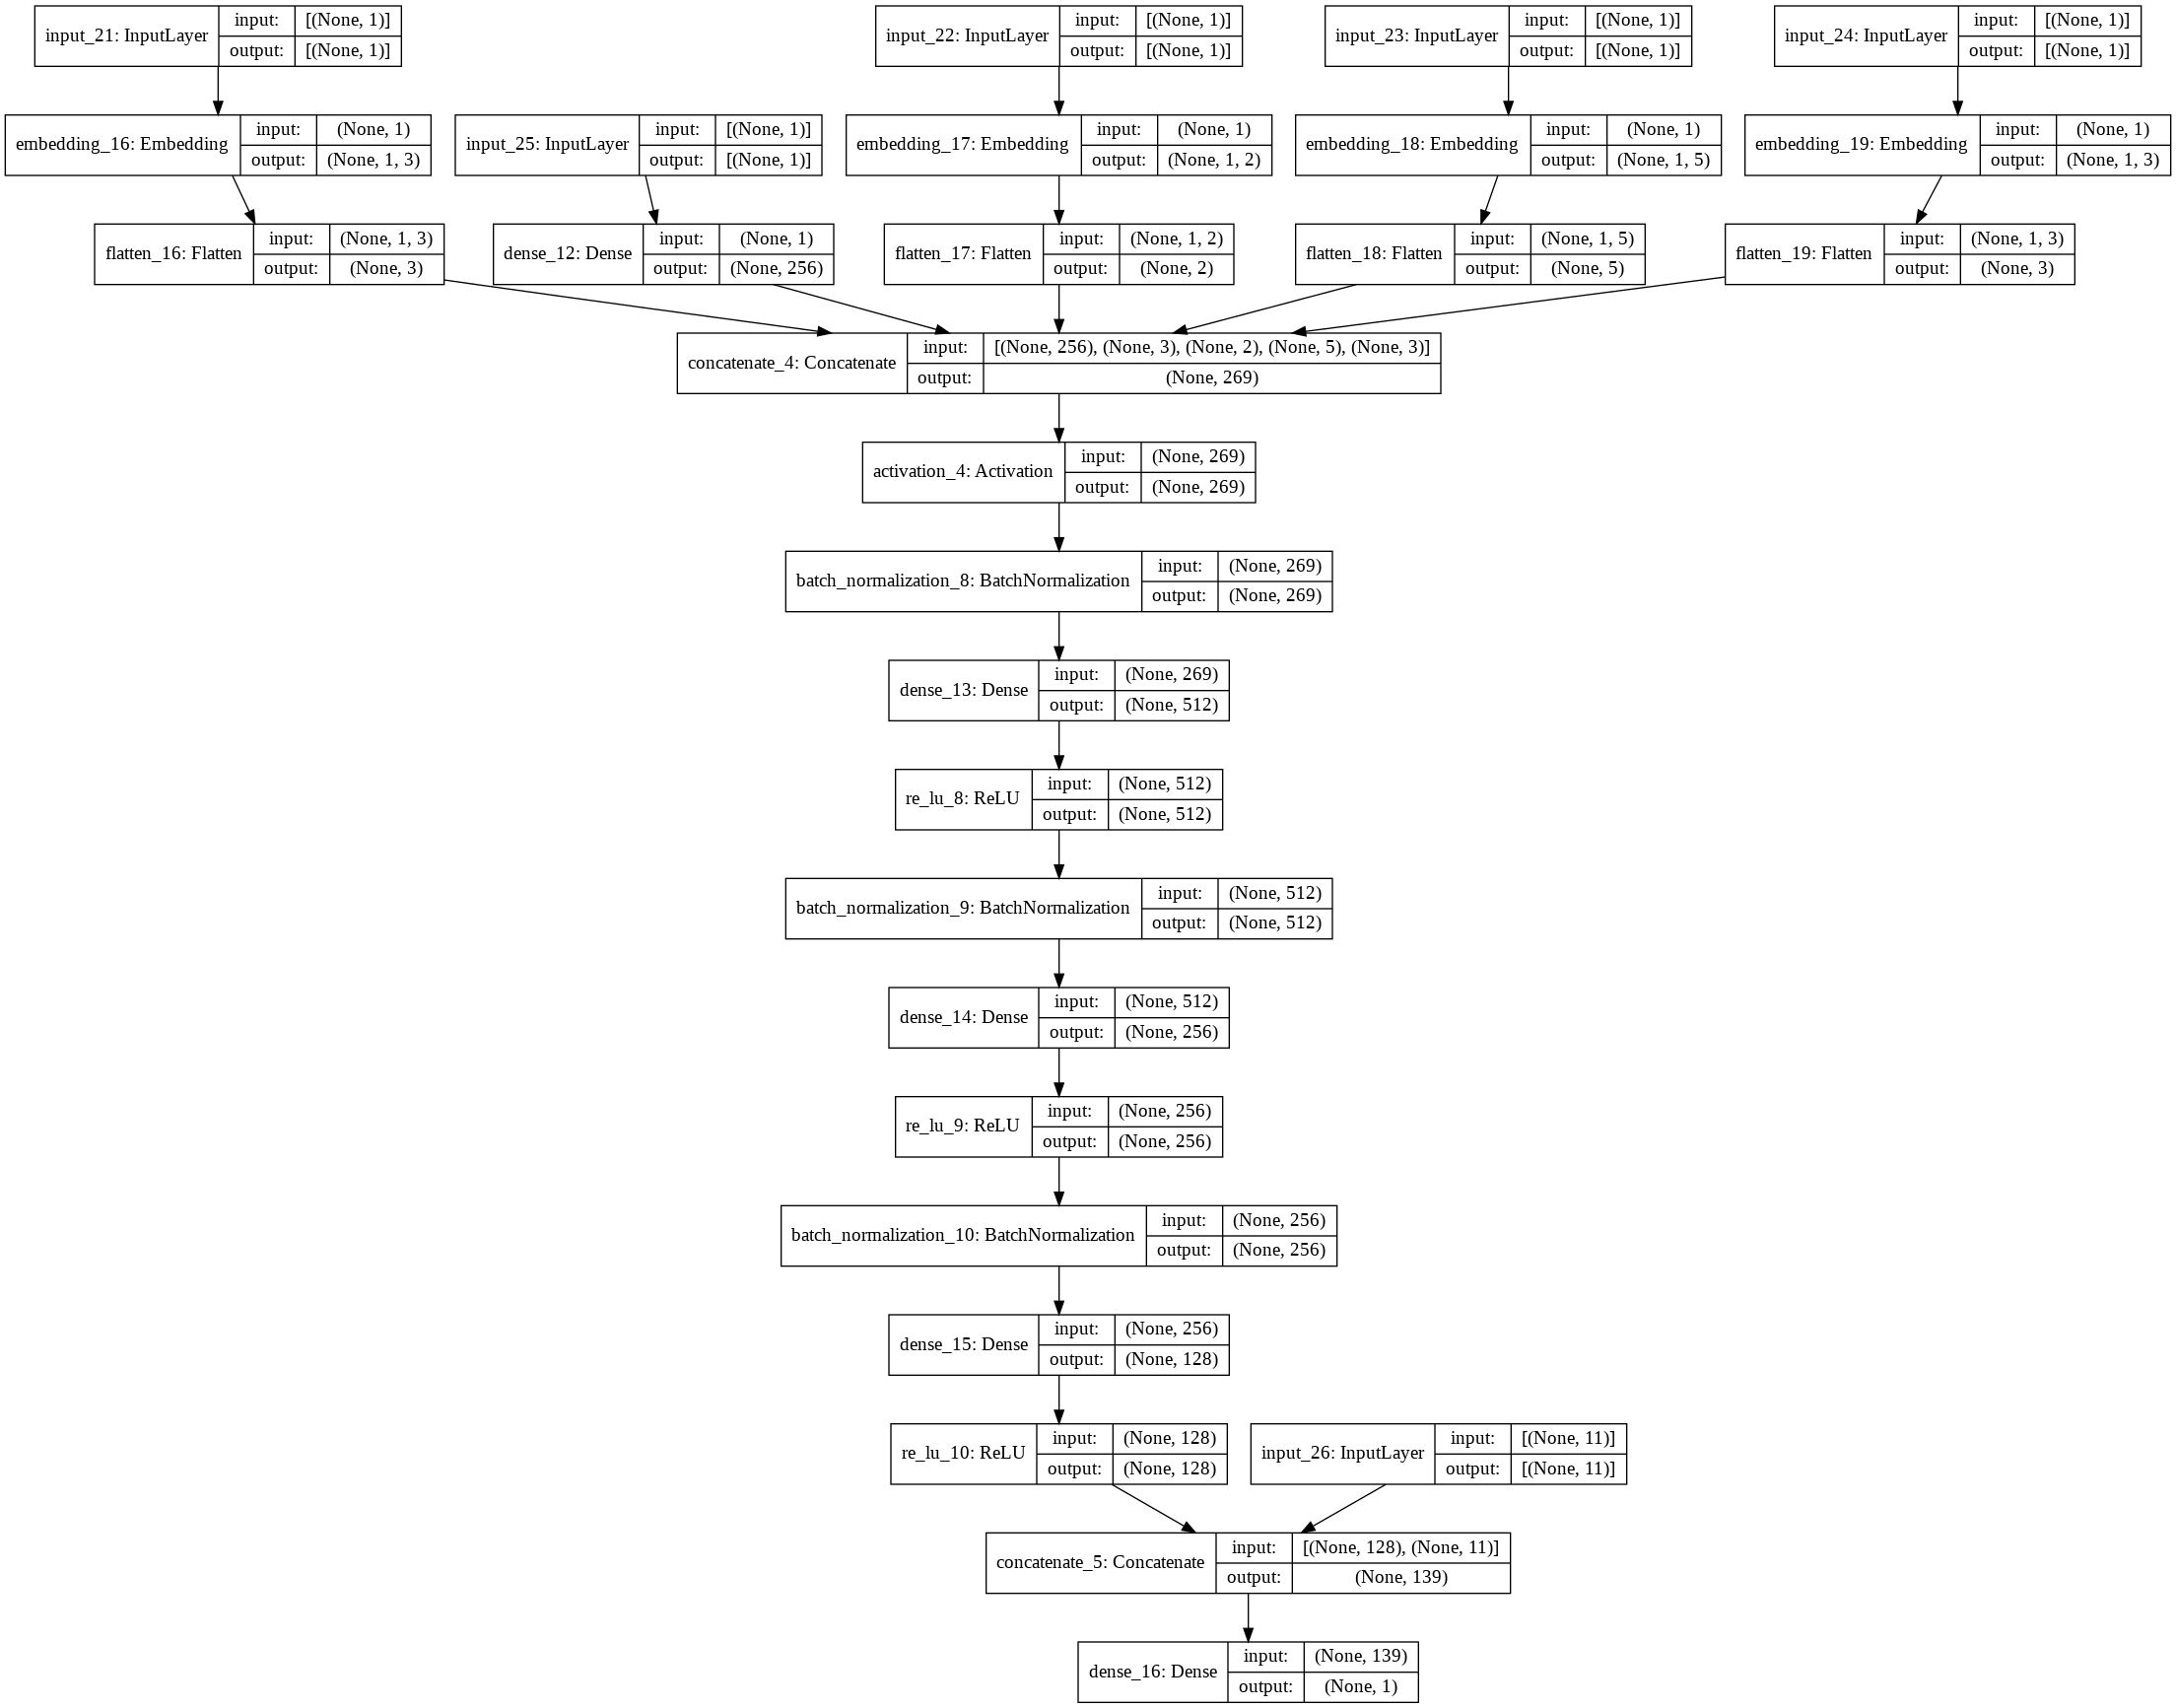

In [63]:
!pip install pydot -q
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [64]:
checkpoint = ModelCheckpoint(
    filepath='./data/wide-deep.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [66]:
# 입력 데이터
input_data = [X_train_continue] + [X_train_category[:, i] for i in range(X_train_category.shape[1])] \
                                   + [X_train_category_poly]

epochs = 30
optimizer= 'adam'
batch_size = 128

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(input_data, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.15,
          callbacks=[checkpoint, early_stopping])

Epoch 1/30
377/377 [==============================] - 5s 7ms/step - loss: 0.4886 - accuracy: 0.7856 - val_loss: 0.5462 - val_accuracy: 0.6841

Epoch 00001: val_loss improved from inf to 0.54622, saving model to ./data/wide-deep.h5
Epoch 2/30
377/377 [==============================] - 3s 7ms/step - loss: 0.4399 - accuracy: 0.8173 - val_loss: 0.4271 - val_accuracy: 0.8214

Epoch 00002: val_loss improved from 0.54622 to 0.42710, saving model to ./data/wide-deep.h5
Epoch 3/30
377/377 [==============================] - 3s 7ms/step - loss: 0.4284 - accuracy: 0.8213 - val_loss: 0.4152 - val_accuracy: 0.8265

Epoch 00003: val_loss improved from 0.42710 to 0.41516, saving model to ./data/wide-deep.h5
Epoch 4/30
377/377 [==============================] - 2s 7ms/step - loss: 0.4245 - accuracy: 0.8214 - val_loss: 0.4114 - val_accuracy: 0.8278

Epoch 00004: val_loss improved from 0.41516 to 0.41136, saving model to ./data/wide-deep.h5
Epoch 5/30
377/377 [==============================] - 3s 7ms/ste

In [67]:
eval_input_data = [X_test_continue] + [X_test_category[:, i] for i in range(X_test_category.shape[1])] \
                    + [X_test_category_poly]

In [68]:
loss, acc = model.evaluate(eval_input_data, y_test)

760/760 [==============================] - 2s 3ms/step - loss: 0.4150 - accuracy: 0.8236


In [69]:
print(f'test_loss:{loss:.4f} - test_acc:{acc:.4f}')

test_loss:0.4150 - test_acc:0.8236


In [70]:
y_test.sum()

15149